In [1]:
import dctkit as dt_
from dctkit import config
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.mesh import util
from dctkit.dec import cochain as C
from dctkit.dec.vector import flat_PDD as flat
from matplotlib import cm
import pygmo as pg
import math
from jax import jit,lax
import time
import jax.numpy as jnp
from functools import partial

In [2]:
config()

# Load data

In [55]:
# SPACE PARAMS
# spatial resolution
dx = 2**4/2**10
L = 2**4 + dx
dx_norm = dx/L
L_norm = 1
#  Number of spatial grid points
nx = int(math.ceil(L / dx))
nx_norm = nx

# vector containing spatial points
x = np.linspace(-L/2, L/2, nx)
x_norm = np.linspace(0, L_norm, nx_norm)
# circumcenters
x_circ = (x[:-1] + x[1:])/2
x_norm_circ = (x_norm[:-1] + x_norm[1:])/2

print(nx)
print(len(x_circ[::4]))
# initial velocity
u_0 = 1* np.exp(-1 * (x_circ + 0.5 * L/4)**2)
umax = np.max(u_0)
print(umax)

1025
256
0.9999388474461465


In [62]:
# TIME PARAMS
T = 10
T_norm = T*umax/L
# temporal resolution
dt = 10/2**13
dt_norm = dt*umax/L
# number of temporal grid points
nt = int(math.ceil(T / dt))
nt_norm = nt

# vector containing time points
t = np.linspace(0, T, nt)  
t_norm = np.linspace(0, T_norm, nt_norm)

print(nt)
print(len(t[::32]))
#Viscosity
nu = 0.1
nu_norm = nu/(L*umax)
print(nu_norm)

8192
256
0.006244284292955893


In [63]:
def main_run_FDM(u,x, dt, dx, nu, max_time_iter):
    for t in range(max_time_iter):
        u[1:-1, t+1] = u[1:-1, t] + dt * (nu * (u[2:, t] - 2 * u[1:-1, t] + u[:-2, t]) / dx**2 
                   - 0.25 * (u[2:, t]**2 - u[:-2, t]**2) / dx)
        #diffusion = epsilon * (u[2:, t] - 2 * u[1:-1, t] + u[:-2, t]) / dx**2
        #flux = (u[2:, t]**2 - u[:-2, t]**2) /(4*dx)
        #u[1:-1, t+1] = 1/2*(u[2:, t] + u[:-2, t]) + dt * (diffusion - flux)
        #print(np.linalg.norm(u[:,t+1]))
    return u

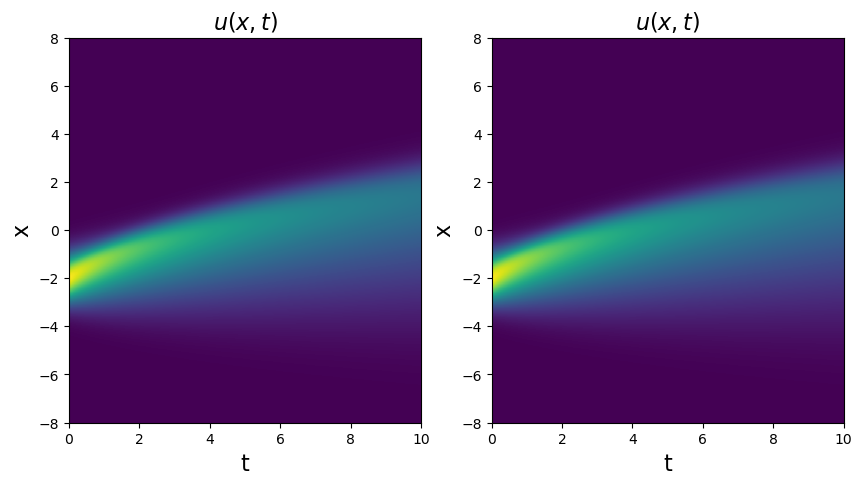

In [64]:
# Array containing velocity
u = np.zeros([nx-1, nt]) 
u_norm = np.zeros([nx_norm-1, nt_norm]) 

# Initial condition
u[:, 0] = u_0
# Boundary condition at x=0
u[0, :] = 0
# Boundary condition at x=xmax
u[-1, :] = 0 

u = main_run_FDM(u, x,dt, dx, nu, nt-1)

# Initial condition
u_norm[:, 0] = u_0/umax
# Boundary condition at x=0
u_norm[0, :] = 0
# Boundary condition at x=xmax
u_norm[-1, :] = 0 
u_norm = main_run_FDM(u_norm, x_norm,dt_norm, dx_norm, nu_norm, nt_norm-1)

# rescale and plot
u_rescaled = u_norm*umax


fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, x_circ, u)
ax[1].pcolormesh(t,x_circ,u_rescaled)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$u(x, t)$', fontsize=16)
plt.show()

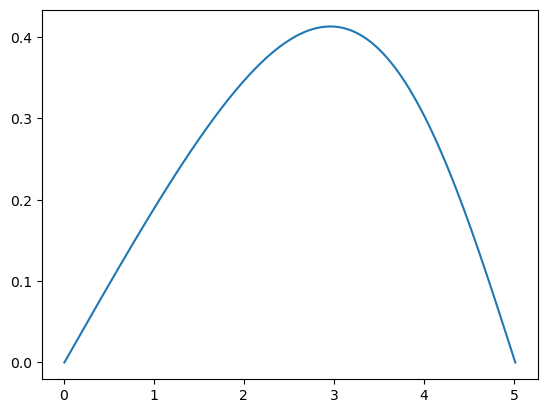

In [35]:
plt.plot(x_circ, u_rescaled[:,-1])
plt.show()

# Solving

In [44]:
# define simplicial complex
mesh, _ = util.generate_line_mesh(nx_norm, L_norm)
S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()

In [45]:
def run(u,dt, nu, scheme: str = "parabolic"):
        """Main run to solve Burgers' equation with DEC.

        Args:
            scheme: discretization scheme used.
        """
        for t in range(nt_norm - 1):
            u_coch = C.CochainD0(S, u[:, t])
            dissipation = C.scalar_mul(C.star(C.coboundary(u_coch)), nu)
            if scheme == "upwind":
                flat_u = flat(u_coch, scheme)
                flux = C.scalar_mul(C.square(C.star(flat_u)), -1/2)
            elif scheme == "parabolic":
                u_sq = C.scalar_mul(C.square(u_coch), -1/2)
                flux = C.star(flat(u_sq, scheme))
            total_flux = C.add(flux, dissipation)
            balance = C.star(C.coboundary(total_flux))
            u[1:-1, t+1] = u[1:-1, t] + dt*balance.coeffs[1:-1]
        return u

In [46]:
# define initial and boundary conditions
u_0 = np.zeros((nx_norm - 1, nt_norm), dtype = dt_.float_dtype)
u_0[:,0] = 2 * np.exp(-2 * (x_circ - 0.5 * L)**2)/umax
u_0[0, :] = 0  
u_0[-1, :] = 0

In [47]:
# solve
u_sol_norm = run(u_0.copy(), dt_norm, nu_norm, "parabolic")

In [50]:
# rescale
u_sol = u_sol_norm*umax

# Plots

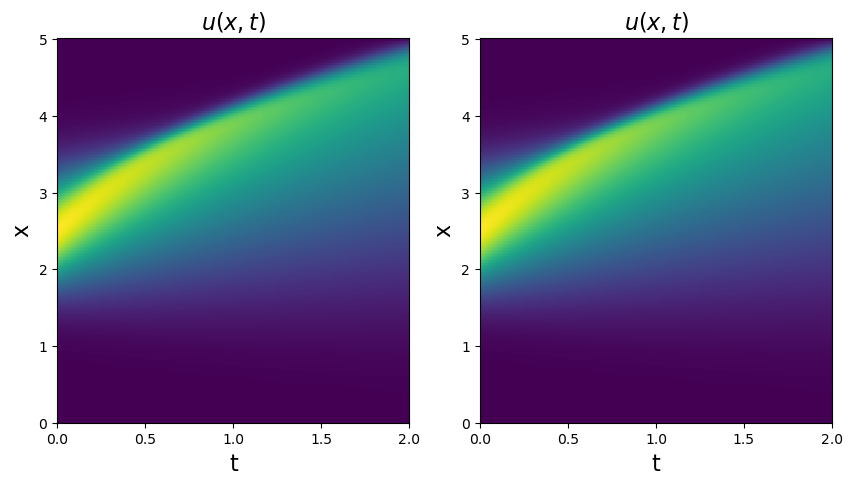

In [35]:
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, x_circ, u_rescaled)
ax[1].pcolormesh(t,x_circ,u_sol)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$u(x, t)$', fontsize=16)
plt.show()

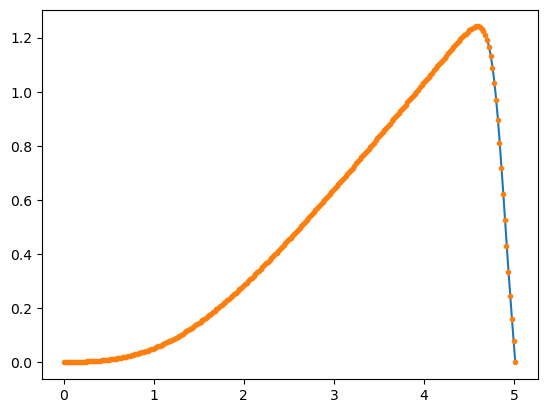

In [36]:
plt.plot(x_circ, u[:,-1])
plt.plot(x_circ, u_sol[:,-1], marker = ".", linewidth = 0.01)
plt.show()

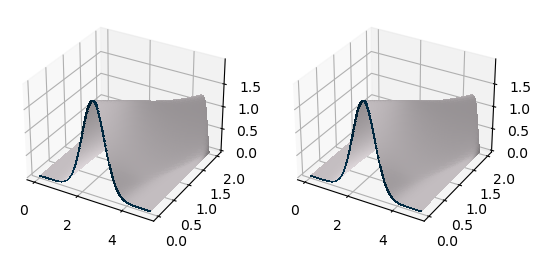

In [37]:
# 3d plot u
fig, ax = plt.subplots(ncols = 2,subplot_kw={"projection": "3d"})
x_mesh, t_mesh = np.meshgrid(x_circ, t)

c = np.zeros_like(u.T)
c[:10,:] = 1

surf_1 = ax[0].plot_surface(x_mesh, t_mesh, u.T, facecolors=cm.PuBu(c), rcount=nx, ccount=nt,
                       linewidth=0, antialiased=False)
surf_2 = ax[1].plot_surface(x_mesh, t_mesh, u_sol.T, facecolors=cm.PuBu(c), rcount=nx, ccount=nt,
                       linewidth=0, antialiased=False)
plt.show() 

# Test with explicit solution

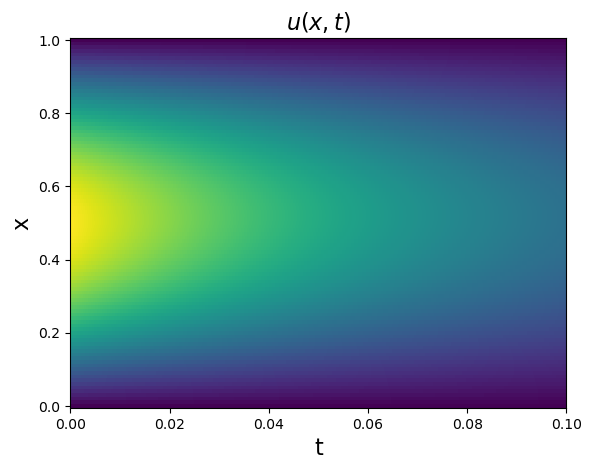

In [15]:
dx = 0.01
x = np.linspace(0, 1, int(1/dx) + 1)
dt = 0.00001
nt = int(0.1/dt) + 1
t = np.linspace(0, 0.1, nt)
nu = 1


u_0 = np.zeros((len(x), len(t)), dtype = dt_.float_dtype)
u_0[:,0] = np.sin(np.pi*x)
u_0[0,:] = 0
u_0[-1,:] = 0


u = main_run_FDM(u_0.copy(), x,dt, dx, nu, nt-1)

plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.show()

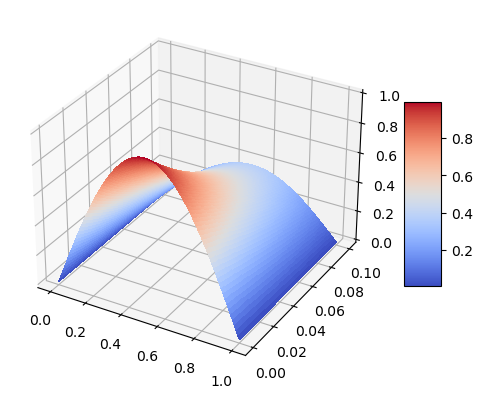

In [16]:
# 3d plot u
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x_mesh, t_mesh = np.meshgrid(x, t)
surf = ax.plot_surface(x_mesh, t_mesh, u.T, cmap=cm.coolwarm, rcount=nx, ccount=nt,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [17]:
# regenerate mesh
tet_node_tags = np.zeros((len(x)-1,2), dtype = dt_.int_dtype)
tet_node_tags[:,0] = np.arange(len(x)-1)
tet_node_tags[:,1] = np.arange(1, len(x))
node_coords = np.zeros((len(x), 2), dtype = dt_.float_dtype)
node_coords[:,0] = x
S = SimplicialComplex(tet_node_tags, node_coords, is_well_centered = True)
S.get_hodge_star()
S.get_flat_PDP_weights()

In [18]:
u_explicit = main_run(u_0.copy(), S, nu, nt - 1, True)

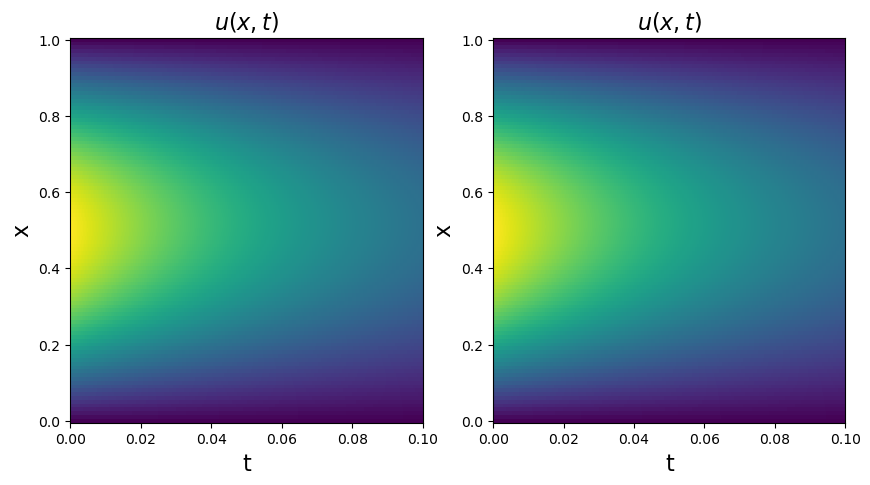

In [19]:
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, x, u)
ax[1].pcolormesh(t,x,u_explicit)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$u(x, t)$', fontsize=16)
plt.show()

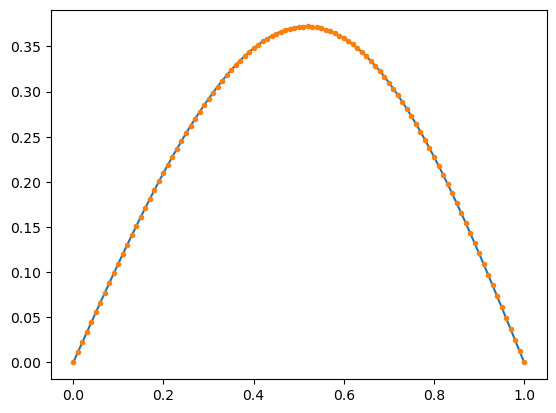

In [20]:
plt.plot(x, u[:,-1])
plt.plot(x, u_explicit[:,-1], marker = ".", linewidth = 0.01)
plt.show()

# Viscosity autotune

In [56]:
# SPACE PARAMS
L = 5
L_norm = 1
# spatial resolution
dx = 0.05
dx_norm = dx/L
#  Number of spatial grid points
nx = int(L / dx)
nx_norm = int(L_norm/ dx_norm)

# vector containing spatial points
x = np.linspace(0, L, nx)
x_norm = np.linspace(0, L_norm, nx_norm)
# circumcenters
x_circ = (x[:-1] + x[1:])/2
x_norm_circ = (x_norm[:-1] + x_norm[1:])/2


# initial velocity
u_0 = 2 * np.exp(-2 * (x_circ - 0.5 * L)**2)
umax = np.max(u_0)

# TIME PARAMS
T = 2
T_norm = T*umax/L
# temporal resolution
dt = 0.01
dt_norm = dt*umax/L
# number of temporal grid points
nt = int(T / dt)
nt_norm = nt

# vector containing time points
t = np.linspace(0, T, nt)  
t_norm = np.linspace(0, T_norm, nt_norm)

#Viscosity
nu = 0.05
nu_norm = nu/(L*umax)

In [57]:
# define simplicial complex
mesh, _ = util.generate_line_mesh(nx_norm, L_norm)
S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()

In [92]:
u_sol_norm_jax = jnp.array(u_sol_norm)

In [123]:
class Problem:
    def __init__(self, dt, nx, nt, u_0):
        self.dt = dt
        self.nx = nx
        self.nt = nt
        self.u_0 = u_0
        self.func = jit(self.burgers_step)
        self.jit_loop = jit(self.main_loop)
        
    
    def burgers_step(self,u_t, nu):
        u_coch = C.CochainD0(S, u_t)
        dissipation = C.scalar_mul(C.star(C.coboundary(u_coch)), nu)
        u_sq = C.scalar_mul(C.square(u_coch), -1/2)
        flux = C.star(flat(u_sq, "parabolic"))
        total_flux = C.add(flux, dissipation)
        balance = C.star(C.coboundary(total_flux))
        burgers_step = balance.coeffs
        burgers_step = burgers_step.at[0].set(0)
        burgers_step = burgers_step.at[-1].set(0)
        return burgers_step


    def body_fun(self,u_t,t, nu):
        balance = self.func(u_t, nu)
        u_tp1 = u_t + self.dt*balance
        current_err = jnp.linalg.norm(u_tp1 - u_sol_norm_jax[:,t+1])**2
        return u_tp1, current_err


    def main_loop(self,nu):
        total_err = 0
        u = jnp.zeros((self.nx - 1, self.nt), dtype = dt_.float_dtype)
        u = u.at[:,0].set(self.u_0)
        u = u.at[0, :].set(0)  
        u = u.at[-1, :].set(0)
    

        u_update, errors = lax.scan(partial(self.body_fun, nu=nu), u[:,0], jnp.arange(self.nt - 1))

        return u_update, errors
                

    def fitness(self,nu):
        u_update, errors = self.jit_loop(nu)
        
        if jnp.isnan(errors).any():
            total_err = 1e5
        else:
           total_err = jnp.mean(errors)
        
        return [total_err]
        

    def get_bounds(self):
        return ([0.00001], [1])

In [92]:
'''
class Problem:
    def __init__(self, dt, nx, nt,u):
        self.dt = dt
        self.nx = nx
        self.nt = nt
        self.u = u
        self.func = jit(self.burgers_step)
        self.jit_loop = jit(self.main_loop)
        self.t = 0
        self.i = 0
        
    def burgers_step(self,u_t, nu):
        u_coch = C.CochainD0(S, u_t)
        dissipation = C.scalar_mul(C.star(C.coboundary(u_coch)), nu)
        u_sq = C.scalar_mul(C.square(u_coch), -1/2)
        flux = C.star(flat(u_sq, "parabolic"))
        total_flux = C.add(flux, dissipation)
        balance = C.star(C.coboundary(total_flux))
        return balance.coeffs

    def body_func(self, total_err):
        # for t in range(self.num_t_points - 1):
        update = self.u[1:-1, self.t] + self.dt * self.func(self.u[:, self.t], self.curr_nu)[1:-1]
        self.u = self.u.at[1:-1, self.t+1].set(update)
        #if self.t in self.time_data:
        total_err += jnp.linalg.norm(self.u[:, self.t] - u_sol_norm[:, self.i])
        self.i += 1
        self.t += 1
        # if np.isnan(self.u[:, t+1]).any() or (np.abs(self.u[:, t+1]) > 1e5).any():
        #    total_err = np.nan
        #    break
        return total_err

    def cond_fun(self, total_err):
        time_condition = self.t < self.nt - 1
        #u_condition_nan = jnp.sum(jnp.isnan(self.u))
        #u_condition_ans = jnp.sum((jnp.abs(self.u[:, self.t+1]) > 1e5))
        #u_condition = u_condition_nan > 0
        #return time_condition and u_condition
        return time_condition
    
    def main_loop(self,nu):
        # total_err = 0
        self.curr_nu = nu
        total_err = lax.while_loop(self.cond_fun, self.body_func, 0)

        # normalize total_err
        total_err /= self.nt

        # for t in range(self.num_t_points - 1):
        #    self.u[1:-1, t+1] = self.u[1:-1, t] + self.dt * \
        #        self.jitted_func(self.u[:, t], epsilon)[1:-1]
        #    if np.isnan(self.u[:, t+1]).any() or (np.abs(self.u[:, t+1]) > 1e5).any():
        #        total_err = np.nan
        #        break

        total_err_1 = jnp.where(self.t < self.nt - 1, 1e5, total_err)
        total_err_2 = jnp.where(jnp.isnan(total_err_1), 1e5, total_err1) 

        #if self.t < self.nt - 1 or math.isnan(total_err):
        #    total_err = 1e5

        # else:
            # evaluate errors
        #    u_data = self.u_data_T.T
        #    errors = self.u[:, self.time_data] - u_data

        #    total_err = np.mean(np.linalg.norm(errors, axis=0)**2)

        return total_err_2

    def fitness(self,nu):
        return [self.jit_loop(nu)]

    def get_bounds(self):
        return ([0.00001], [1])
'''

'\nclass Problem:\n    def __init__(self, dt, nx, nt,u):\n        self.dt = dt\n        self.nx = nx\n        self.nt = nt\n        self.u = u\n        self.func = jit(self.burgers_step)\n        self.jit_loop = jit(self.main_loop)\n        self.t = 0\n        self.i = 0\n        \n    def burgers_step(self,u_t, nu):\n        u_coch = C.CochainD0(S, u_t)\n        dissipation = C.scalar_mul(C.star(C.coboundary(u_coch)), nu)\n        u_sq = C.scalar_mul(C.square(u_coch), -1/2)\n        flux = C.star(flat(u_sq, "parabolic"))\n        total_flux = C.add(flux, dissipation)\n        balance = C.star(C.coboundary(total_flux))\n        return balance.coeffs\n\n    def body_func(self, total_err):\n        # for t in range(self.num_t_points - 1):\n        update = self.u[1:-1, self.t] + self.dt * self.func(self.u[:, self.t], self.curr_nu)[1:-1]\n        self.u = self.u.at[1:-1, self.t+1].set(update)\n        #if self.t in self.time_data:\n        total_err += jnp.linalg.norm(self.u[:, self.t] - 

In [166]:
prb = Problem(dt=dt_norm, nx=nx_norm, nt=nt_norm, u_0=u_0/umax)
algo = pg.algorithm(pg.de(gen=20))

In [169]:
#u = jnp.zeros((nx_norm - 1, nt_norm), dtype = dt_.float_dtype)
#u = u.at[:,0].set(u_0/umax)
#u = u.at[0, :].set(0)  
#u = u.at[-1, :].set(0)


#algo.set_verbosity(2)
tic = time.time()
prob = pg.problem(prb)
pop = pg.population(prob, size=200)
pop = algo.evolve(pop)
toc = time.time()
print(toc-tic)

0.9717683792114258


In [170]:
print("RESULTS")
#print("-----------------------------------------------------------")
#print(f"The best possible fitness is {prb.fitness(nu_norm)[0]}")
#print(f"The best fitness is {pop.champion_f[0]}")
print("-----------------------------------------------------------")
print(f"The best possible viscosity is {nu_norm}")
print(f"The best viscosity is {pop.champion_x[0]}")

RESULTS
-----------------------------------------------------------
The best possible viscosity is 0.005
The best viscosity is 0.0050444186659201196


In [137]:
tic = time.time()
print(prb.fitness(nu_norm)[0])
toc = time.time()
print(toc-tic)

4.712783174615725e-31
0.14066576957702637


In [138]:
tic = time.time()
prb.fitness(0.001)[0]
toc = time.time()
print(toc-tic)

0.16249513626098633


In [139]:
nu_list = 0.005*np.arange(1,4)
for nu in nu_list:
    fit = prb.fitness(nu)[0]
    print(fit)

4.712783174615725e-31
0.13911837741824898
100000.0
